In [43]:
import pywt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops_table
import pandas as pd
import napari
from napari.utils import nbscreenshot
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import RandomForestClassifier

## Random Composite Signal Generation

In [2]:
seed = 42
np.random.seed(seed)


n_samples = 500
freq = 5
time = np.linspace(0, 1, n_samples)

* Signal1: gaussian
* Signal2: Cardiac AP
* Signal3: Decreasing Monoexponential

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_18408\2929572496.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  signal1 = signal.gaussian(30, std=3)


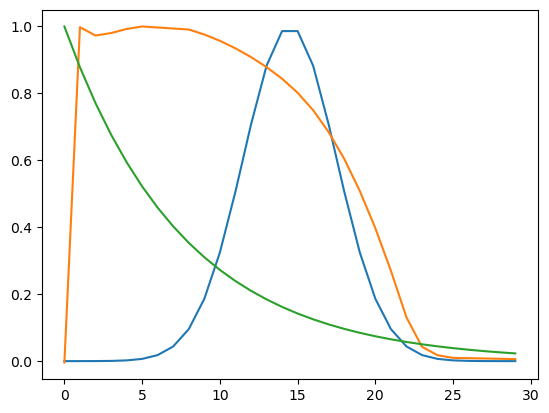

In [3]:
# Signal1: Gaussian
signal1 = signal.gaussian(30, std=3)

# Signal2: Cardiac Ventricular Action Potential
AP_original = np.loadtxt(r"C:\Users\mazo260d\Documents\GitHub\metroid\Simulated_Data\AP.txt",delimiter='\t')
time_sub = np.linspace(0, 5, n_samples) #time vector

# Re-sample at a constant sampling frequency
AP_original[:,0] = AP_original[:,0]/1000                       #ms to sec
xvals = np.arange(AP_original[0,0], AP_original[-1,0], 0.0001) #generate a time vetor with a constant sampling frequency
yinterp = np.interp(xvals, AP_original[:,0], AP_original[:,1]) #interpolate values where original AP time data is missing

# Re-sample by number of samples
yinterp1 = np.interp(time_sub, xvals, yinterp)   #interpolate (extend) data to whole time vector
# Normalize
signal2 = yinterp1
signal2 = signal2+abs(signal2[-1])                          #shift amp from ~-80 to 0
signal2 = signal2/np.amax(signal2)                          #normalize amplitude
# Crop
signal2 = signal2[:30]

# Signal3: Decreasing Monoexponential
def monoexp(x, a, b):
    return a * np.exp(-b * x)
b=0.13
a=1
x = np.arange(30)
signal3 = monoexp(x, a, b)

signals_dict = {0: signal1,
                1: signal2,
                2: signal3}

plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)

## Make a random signal composition by adding the three signals with random amplitudes and time shifts

In [4]:
def generate_random_signal_composition(signals_dict, n_samples=500, min_gap=5, max_gap=100):
    composite_signal = np.zeros(n_samples)
    
    position = 0
    while position < n_samples:
        start = position
        # width = np.random.randint(min_width, max(min(max_width, n_samples - position), min_width + 1) + 1)
        signal = signals_dict[np.random.randint(low=0, high=len(signals_dict))]
        width = min(len(signal), n_samples - position)
        composite_signal[start:start+width] = signal[:width]
        position += width + np.random.randint(min_gap, max_gap)  # Move to the end of that window and add some space

    return composite_signal

In [5]:
composite_signal = generate_random_signal_composition(signals_dict=signals_dict)

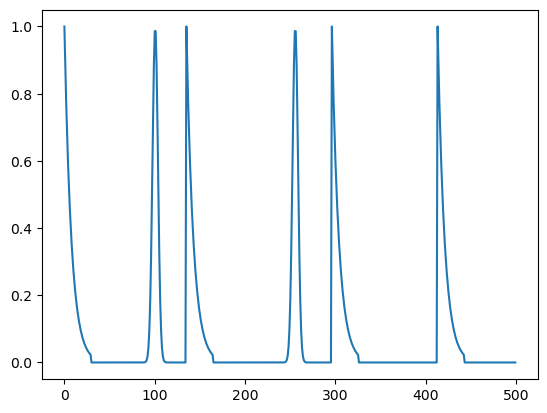

In [6]:
plt.plot(composite_signal)

## Generate random objects

In [7]:
# Generate objects

disk = morphology.disk(4)
square = morphology.square(9)
square[square == 1] = 2
diamond = morphology.diamond(4)
diamond[diamond == 1] = 3
objects_list = [disk, square, diamond]
image = np.zeros((100, 100))
object_order = []
for i in range(10):
    for j in range(3):
        n = np.random.randint(low=2, high=5)
        # obj = objects_list[n]
        obj = morphology.disk(n)
        image[i * 10: i * 10 + (n*2 + 1), 20 + j * 20: 20 + j * 20 + (n*2 + 1)] = obj
        object_order.append(n)

## Add composite signals to objects

In [8]:
# Add signals to label image

label_image = label(image)
height, width = image.shape
time_points = n_samples
time_lapse = np.zeros((time_points, height, width))
for i in range(label_image.max()):
    # print(object_order[i])
    # for label in [1, 2, 3]:
    mask = (label_image == i + 1)  # create boolean mask for current label
    # current_signal = signals[object_order[i]]  # get corresponding signal for current label
    current_signal = generate_random_signal_composition(signals_dict)

    # Add random phase by shifting signal
    random_shift = np.random.random()
    current_signal = np.roll(current_signal, int(random_shift * len(current_signal)))

    
    # Add random offset
    current_signal = current_signal + np.random.random() * 5

    # # Add random window pulses
    # random_windows = generate_random_window_mask()
    # current_signal[~random_windows] = 0

    # Add random noise
    current_signal = current_signal + np.random.random(size=len(current_signal)) / 10

    time_lapse[:, mask] = current_signal.reshape((time_points, -1))  # assign signal to region corresponding to current label

## Add mean_intensities of random objects over time to a table

In [9]:
df = pd.DataFrame([])
for i in range(time_points):
    features = regionprops_table(label_image, intensity_image=time_lapse[i], properties=('label', 'mean_intensity'))
    features['frame'] = i
    # data = features.values()
    df = pd.concat([df, pd.DataFrame(features)])

In [10]:
df

,label,mean_intensity,frame
0,1,3.477317,0
1,2,2.538447,0
2,3,1.398264,0
3,4,0.913758,0
4,5,0.505126,0
...,...,...,...
25,26,3.999081,499
26,27,0.277202,499
27,28,0.559926,499
28,29,3.634906,499


## Add data to napari

In [11]:
# viewer = napari.Viewer()
# averages = np.mean(time_lapse, axis=(1, 2))
# viewer.add_image(time_lapse, name='time-lapse')
# table = df

# viewer.add_labels(label_image, features=table, name='labels')

## Annotate some signals

![](./screenshots/signal_annotations1.png)

![](./screenshots/signal_annotations2.png)

In [12]:
# nbscreenshot(viewer)

In [13]:
# nbscreenshot(viewer)

## Save table with annotations to disk

In [14]:
# table = viewer.layers[-1].features

# table.to_csv('table_with_annotations.csv')

table = pd.read_csv('table_with_annotations.csv')
table

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,1,2,2.538447,0,0
2,2,3,1.398264,0,0
3,3,4,0.913758,0,0
4,4,5,0.505126,0,0
...,...,...,...,...,...
14995,14995,26,3.999081,499,0
14996,14996,27,0.277202,499,0
14997,14997,28,0.559926,499,0
14998,14998,29,3.634906,499,0


## Get training data

Get labels where some annotations are present

In [15]:
annotations_mask = table['Annotations'] != 0
labels_with_annotations = np.unique(table[annotations_mask]['label'].values)
labels_with_annotations

array([1, 2, 3], dtype=int64)

In [16]:
# get table rows where label matches labels_with_annotations
table_training = table[table['label'].isin(labels_with_annotations)].sort_values(by=['label', 'frame']).reset_index(drop=True)
table_training

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,30,1,3.499637,1,0
2,60,1,3.433654,2,0
3,90,1,3.455424,3,0
4,120,1,3.434541,4,0
...,...,...,...,...,...
1495,14852,3,1.375912,495,0
1496,14882,3,1.394512,496,0
1497,14912,3,1.449024,497,0
1498,14942,3,1.435429,498,0


In [17]:
# table_training = table[(table['label'] == 1) | table['label'] == 2 | (table['label'] == 3)].sort_values(by=['label', 'frame']).reset_index(drop=True)
# table_training

In [18]:
data = table_training['mean_intensity'].values
annotations = table_training['Annotations'].values

# OR (smaller sample)

# # Sample data
# data = np.array([0, 1, 2, 0, 0, 3, 4, 5, 0, 6, 0, 1, 2, 0, 0, 0, 6, 0])
# annotations = np.array([0, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 1, 0, 0, 0, 3, 0])

In [19]:
np.count_nonzero(annotations)

471

In [20]:
len(annotations)

1500

Functions to extract annotated signal parts

In [21]:
def extract_signal_regions(data, annotations):
    # Use a dictionary to store signals by class
    signals_by_class = {}
    
    # Initialize variables for currently observed signal and its starting index
    current_signal = 0
    start_index = None
    
    for i, ann in enumerate(annotations):
        if ann > 0:  # Signal detected
            if current_signal == 0:  # New signal starts
                current_signal = ann
                start_index = i
            elif current_signal != ann:  # Different signal detected
                # Store the previous signal
                if current_signal not in signals_by_class:
                    signals_by_class[current_signal] = []
                signals_by_class[current_signal].append(data[start_index:i])
                
                # Start tracking the new signal
                current_signal = ann
                start_index = i
        else:  # Noise detected
            if current_signal > 0:  # Previous signal ends
                # Store the signal
                if current_signal not in signals_by_class:
                    signals_by_class[current_signal] = []
                signals_by_class[current_signal].append(data[start_index:i])
                
                # Reset tracking variables
                current_signal = 0
                start_index = None
    
    # Handle the case where the last signal goes until the end of the array
    if current_signal > 0:
        if current_signal not in signals_by_class:
            signals_by_class[current_signal] = []
        signals_by_class[current_signal].append(data[start_index:])
    
    return signals_by_class




In [22]:
def extract_signal_regions2(data, annotations):
    signals_by_class = {}
    # Split annotations in lists
    annotation_indices_list = [np.ravel((annotations == i).nonzero()) for i in range(1, max(annotations)+1)]
    for signal_class, annotation_indices in enumerate(annotation_indices_list):
        # Get a mask where transitions occur in annotations
        indices_transition_mask = np.diff(annotation_indices, prepend=0) > 1
        # Get maks indices where transitions occur
        transition_indices = np.flatnonzero(indices_transition_mask)
        transition_indices = transition_indices.tolist()
        # Insert first and last indices
        if transition_indices[0] != 0:
            transition_indices.insert(0,0)
        transition_indices.append(len(annotation_indices))
        # Store all annotated signal parts to the corresponding class
        for start, end in zip(transition_indices[:-1], transition_indices[1:]):
            if signal_class+1 not in signals_by_class:
                signals_by_class[signal_class+1] = []
            signals_by_class[signal_class+1].append(data[annotation_indices[start: end]])
    return signals_by_class

Benchmark functions

In [23]:
%%timeit
# Test the function
result = extract_signal_regions(data, annotations)
result

172 µs ± 6.55 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
%%timeit
# Test the function
result2 = extract_signal_regions2(data, annotations)
result2

162 µs ± 3.45 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
signals_by_class = extract_signal_regions2(data, annotations)
signals_by_class

{1: [array([3.45339942, 3.47916398, 4.48078253, 4.44836907, 4.42411357,
         4.46497301, 4.45461028, 4.51046437, 4.49516011, 4.47941724,
         4.41597458, 4.3991619 , 4.35507975, 4.39603392, 4.30612008,
         4.30411613, 4.23840426, 4.25558943, 4.1479893 , 4.07688484,
         3.99418121, 3.82741188, 3.74669089, 3.6011852 , 3.4794378 ,
         3.52819961, 3.48590347, 3.49459218, 3.51225723, 3.48574261,
         3.45196733]),
  array([3.44934285, 3.45572504, 4.43955851, 4.4297595 , 4.4537887 ,
         4.48294605, 4.49303708, 4.49557219, 4.48468989, 4.47534823,
         4.41612673, 4.41357736, 4.39880788, 4.33325677, 4.34786801,
         4.30381606, 4.29844326, 4.26380314, 4.15605278, 4.05282592,
         3.92896968, 3.90594307, 3.77816072, 3.57250011, 3.52867279,
         3.44145771, 3.44263847, 3.4467946 ]),
  array([3.43925707, 3.44291139, 3.44831437, 4.44018528, 4.43456337,
         4.39987299, 4.43682501, 4.45743827, 4.47357135, 4.43736449,
         4.4205628 , 4.3999961

Get one sub-signal as a test

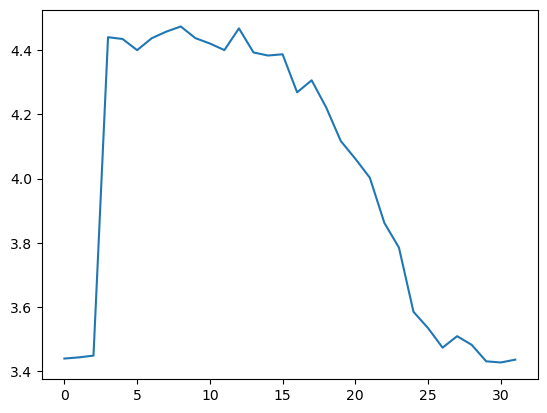

In [26]:
sub_signal1 = signals_by_class[1][2]
plt.plot(sub_signal1)

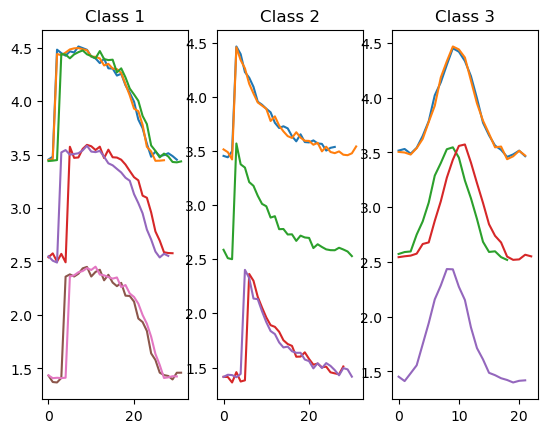

In [27]:
# Plot all signals separated by class in a different column
fig, ax = plt.subplots(1, len(signals_by_class))
for i, (signal_class, signals) in enumerate(signals_by_class.items()):
    for sig in signals:
        ax[i].plot(sig)
    ax[i].set_title(f'Class {signal_class}')


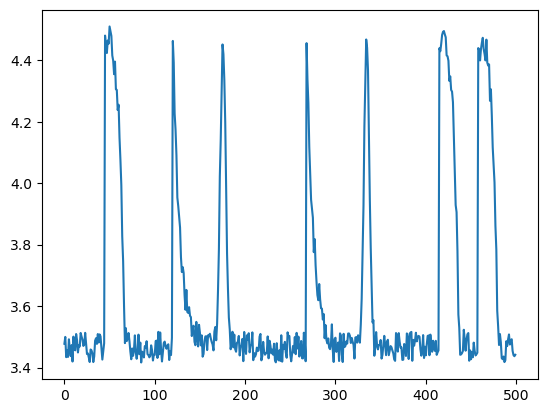

In [28]:
composite_signal1 = table[(table['label'] == 1)].sort_values(by=['label', 'frame']).reset_index(drop=True)['mean_intensity'].values
plt.plot(composite_signal1)

Calculate cross-correlation between each normalized signal class and whole normalized annotated composite signal and plot results

In [29]:
len(signals_by_class.items())

3

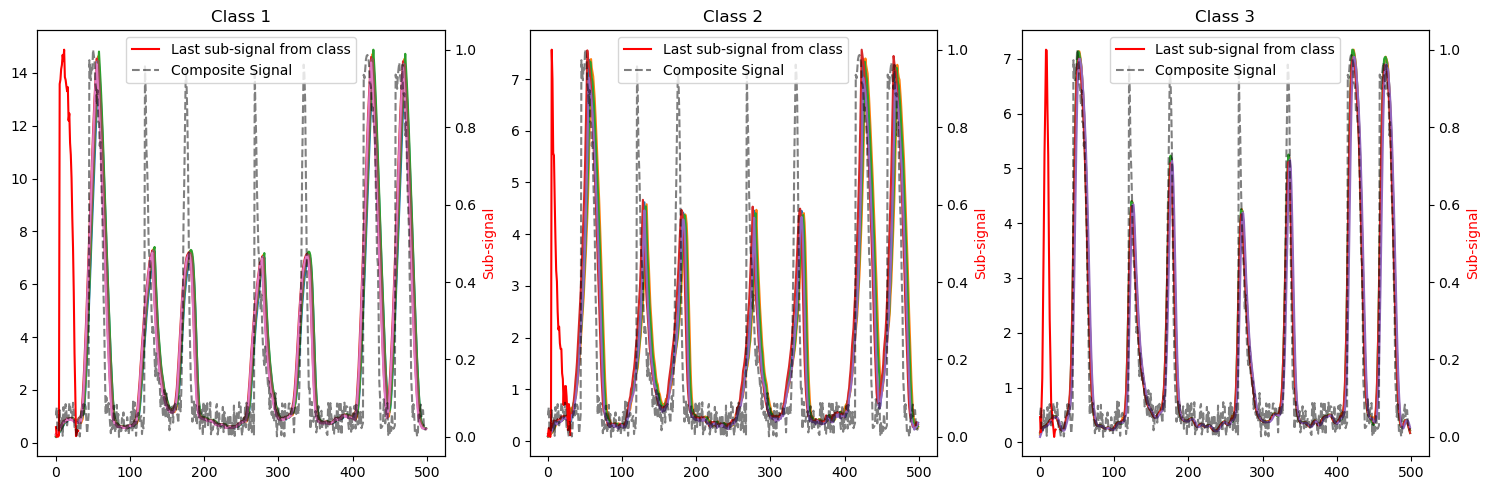

In [52]:
# Calculate cross correlation betwin composite signal and one sub-signal of each class and plot them in a single plot in different columns, including the sub-signal
fig, ax = plt.subplots(1, len(signals_by_class), figsize=(15, 5))
for i, (signal_class, signals) in enumerate(signals_by_class.items()):
    for sig in signals:
        composite_signal_normalized_shifted = (composite_signal1 - np.amin(composite_signal1))/np.ptp(composite_signal1)
        sig_normalized = (sig - np.amin(sig))/np.ptp(sig)
        cross_corr = signal.correlate(composite_signal_normalized_shifted, sig_normalized, mode='same')
        # cross_corr_shifted = cross_corr - np.amin(cross_corr)
        ax[i].plot(cross_corr, label=('cc between composite and sub-signal #' + str(i)))
    ax[i].set_title(f'Class {signal_class}')
    ax2 = ax[i].twinx()
    ax2.plot(sig_normalized, 'r', label='Last sub-signal from class')
    ax2.set_ylabel('Sub-signal', color='r')
    ax2.plot(composite_signal_normalized_shifted, 'k--', label='Composite Signal', alpha=0.5)
    plt.legend()
plt.tight_layout()

## Calculate features for each annotated signal and put them in a table

Sub_signals may have different lengths depending on the user annotations. Example: Signal 1 (cardiac AP)

In [31]:
for sig in signals_by_class[1]:
    print(len(sig))

31
28
32
30
29
32
31


Use SignalSegment class to store sub_signals, their category (annotation), start and end frames, and method to re-sample them to a same length.

In [32]:
class SignalSegment:
    def __init__(self, data, category, label, start_frame, end_frame):
        self.data = data  # The signal data
        self.category = category  # The class/annotation of the signal
        self.label = label  # The label of the signal
        self.start_frame = start_frame  # The starting frame of the signal segment
        self.end_frame = end_frame  # The ending frame of the signal segment

    def __repr__(self):
        return f"<SignalSegment category={self.category}, label={self.label}, frames={self.start_frame}-{self.end_frame}, data_length={len(self.data)}>"
    
    def resample(self, n_samples):
        # Resample the signal segment to a fixed number of samples
        # self.data = signal.resample(self.data, n_samples)
        x = np.arange(len(self.data))
        x_new = np.linspace(0, len(self.data), n_samples)
        spline = make_interp_spline(x, self.data, k=3)
        self.data = spline(x_new)
        


In [33]:
def extract_sub_signals(data, annotations, labels, frames):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    data : np.ndarray
        The signal data array.
    annotations : np.ndarray
        The annotations array.
    labels : np.ndarray
        The labels array.
    frames : np.ndarray
        The frames array.
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    sub_signals_list = []
    current_signal = 0
    start_index = None

    for i, ann in enumerate(annotations):
        if ann > 0:  # Signal detected
            if current_signal == 0:  # New signal starts
                current_signal = ann
                start_index = i
            elif current_signal != ann:  # Different signal detected, save previous
                # Adjusted to include label and frame information
                segment = SignalSegment(data[start_index:i], current_signal, labels[start_index], frames[start_index], frames[i-1])
                sub_signals_list.append(segment)
                
                current_signal = ann
                start_index = i
        else:  # Noise detected, save previous signal
            if current_signal > 0:
                segment = SignalSegment(data[start_index:i], current_signal, labels[start_index], frames[start_index], frames[i-1])
                sub_signals_list.append(segment)
                
                current_signal = 0
                start_index = None
    
    # Handle the case where the last signal goes until the end
    if current_signal > 0:
        segment = SignalSegment(data[start_index:], current_signal, labels[start_index], frames[start_index], frames[-1])
        sub_signals_list.append(segment)
    
    return sub_signals_list


Small test set

In [34]:
data1 = np.array([0, 1, 2, 0, 0, 3, 4, 5, 0, 6, 0, 1, 2, 0, 0, 0, 6, 0]) # intensity values
annotations1 = np.array([0, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 1, 0, 0, 0, 3, 0])
label1 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2])
frame1 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])

Benchmark function

In [35]:
%%timeit
signals_by_class = extract_sub_signals(data1, annotations1, label1, frame1)
# signals_by_class

7.88 µs ± 546 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [36]:
data = table_training['mean_intensity'].values
annotations = table_training['Annotations'].values
labels = table_training['label'].values
frames = table_training['frame'].values

In [37]:
sub_signals_list = extract_sub_signals(data, annotations, labels, frames)

Re-sample all sub_signals to the same length

In [38]:
max_sub_signal_length = max([len(sig.data) for sig in sub_signals_list])
max_sub_signal_length


32

In [39]:
# Resample all signals to the same length
for sig in sub_signals_list:
    sig.resample(max_sub_signal_length)

In [40]:
sub_signals_list

[<SignalSegment category=1, label=1, frames=43-73, data_length=32>,
 <SignalSegment category=2, label=1, frames=117-143, data_length=32>,
 <SignalSegment category=3, label=1, frames=166-187, data_length=32>,
 <SignalSegment category=2, label=1, frames=265-296, data_length=32>,
 <SignalSegment category=3, label=1, frames=325-346, data_length=32>,
 <SignalSegment category=1, label=1, frames=413-440, data_length=32>,
 <SignalSegment category=1, label=1, frames=455-486, data_length=32>,
 <SignalSegment category=3, label=2, frames=17-35, data_length=32>,
 <SignalSegment category=1, label=2, frames=118-147, data_length=32>,
 <SignalSegment category=3, label=2, frames=225-247, data_length=32>,
 <SignalSegment category=1, label=2, frames=285-313, data_length=32>,
 <SignalSegment category=2, label=2, frames=410-440, data_length=32>,
 <SignalSegment category=1, label=3, frames=213-244, data_length=32>,
 <SignalSegment category=1, label=3, frames=286-316, data_length=32>,
 <SignalSegment category

Place resampled sub_signals in a table to compute features using tsfresh

In [41]:
# Place resampled sub_signals  while adding their annotations, frames and labels, in a table
df_resampled = pd.DataFrame([])
for i, sig in enumerate(sub_signals_list):
    sub_table = pd.DataFrame(sig.data, columns=['mean_intensity'])
    sub_table['sub_label'] = i
    sub_table['original_label'] = sig.label
    sub_table['original_start_frame'] = sig.start_frame
    sub_table['original_end_frame'] = sig.end_frame
    sub_table['frame'] = np.arange(0, len(sig.data))
    sub_table['category'] = sig.category

    df_resampled = pd.concat([df_resampled, sub_table], axis=0)
df_resampled

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category
0,3.453399,0,1,43,73,0,1
1,3.479164,0,1,43,73,1,1
2,4.480783,0,1,43,73,2,1
3,4.448369,0,1,43,73,3,1
4,4.424114,0,1,43,73,4,1
...,...,...,...,...,...,...,...
27,1.428026,16,3,448,478,27,2
28,1.494664,16,3,448,478,28,2
29,1.482570,16,3,448,478,29,2
30,1.415668,16,3,448,478,30,2


Maybe do not feed the whole table, but only intensities and ids

In [42]:
# tsfresh syntax for extracting features
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

table_training = df_resampled[['mean_intensity', 'sub_label', 'frame']]

extraction_settings = ComprehensiveFCParameters()

signal_features_table_training = extract_features(table_training, column_id='sub_label', column_sort='frame',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 17/17 [00:11<00:00,  1.44it/s]


In [117]:
signal_features_table_training

,mean_intensity__variance_larger_than_standard_deviation,mean_intensity__has_duplicate_max,mean_intensity__has_duplicate_min,mean_intensity__has_duplicate,mean_intensity__sum_values,mean_intensity__abs_energy,mean_intensity__mean_abs_change,mean_intensity__mean_change,mean_intensity__mean_second_derivative_central,mean_intensity__median,...,category__fourier_entropy__bins_5,category__fourier_entropy__bins_10,category__fourier_entropy__bins_100,category__permutation_entropy__dimension_3__tau_1,category__permutation_entropy__dimension_4__tau_1,category__permutation_entropy__dimension_5__tau_1,category__permutation_entropy__dimension_6__tau_1,category__permutation_entropy__dimension_7__tau_1,category__query_similarity_count__query_None__threshold_0.0,category__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,128.659991,522.925502,0.081638,0.000426,-0.000185,4.193197,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,119.999916,452.596621,0.088432,-0.003723,-0.003527,3.652348,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,121.322724,463.977564,0.076574,-0.008784,-0.003394,3.633539,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,3.0
3,0.0,0.0,0.0,0.0,118.658982,442.293133,0.082028,0.005648,0.003175,3.607866,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,121.178887,463.035629,0.077698,-0.008034,-0.002966,3.620959,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,3.0
5,0.0,0.0,0.0,0.0,130.225233,535.638883,0.083426,-0.005562,-0.001356,4.296854,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,127.741764,515.859213,0.079952,-0.001402,-0.000553,4.116691,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,93.727501,278.648197,0.072188,0.003474,0.001715,2.809412,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,3.0
8,0.0,0.0,0.0,0.0,99.674720,316.317221,0.096000,-0.004351,-0.003514,3.302937,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,91.242449,264.465096,0.077226,-0.006403,-0.003032,2.687080,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,3.0


In [49]:
annotations = [sub_sig.category for sub_sig in sub_signals_list]
annotations


[1, 2, 3, 2, 3, 1, 1, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2]

### Train Classifier

In [50]:
random_state = 42
classifier = RandomForestClassifier(random_state=random_state)
classifier_path = 'sub_signal_classifier.pkl'

# X_train = signal_features_table_training.iloc[:, 1:] # remove the first column (the object_id)

# # imput mean to handle NaN values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=False)
# X_imputed_train = imputer.fit_transform(X_train)

classifier.fit(signal_features_table_training, annotations)

train_score = classifier.score(signal_features_table_training, annotations)
print(train_score)

1.0


## Detect regions of interest
Find peaks by thresholding cross-correlation and get a region around them.
Develop some strategy to collect these regions without duplication (or collect duplication, but assign some weight or probability to them)


## !Stopped here!

- train classifier with these features and annotated sub_signals
- Detect non-annotated sub_signals (using cross-correlation)
- Classify them

## Get all windows where there is a high cross-correlation peak, calculate the same features and add them to the table with annotation class 0

Display wavelet coefficients for each signal

In [23]:
len(signals_by_class[1][0])

31

In [24]:
# First signal of class 1 = signals_by_class[1][0]
waveletname = 'db4'
# Get max level of discrete wavelet
max_level_of_decomposition = pywt.dwt_max_level(len(signals_by_class[1][0]), waveletname)
print(max_level_of_decomposition)


2


In [25]:
def make_list_of_coefficients_names(waveletname, max_level_of_decomposition):
    list_coefficients_names = [waveletname + '_cA_' + str(max_level_of_decomposition)]
    list_coefficients_names += [waveletname + '_cD_' + str(i) for i in range(max_level_of_decomposition, 0, -1)]
    return list_coefficients_names

In [26]:
list_wavelet_coefficients = pywt.wavedec(signals_by_class[1][0], waveletname, level=max_level_of_decomposition)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients

[array([8.45641474, 7.2552391 , 9.22873853, 7.6903417 , 7.88126519,
        8.9506319 , 8.90890409, 8.7053209 , 8.47328454, 7.62091933,
        7.04237105, 6.95136322, 6.93967763]),
 array([-0.20218199, -0.5755312 ,  0.53312635, -0.1546327 , -0.00538744,
        -0.00606577, -0.00172286, -0.08456947,  0.08235799, -0.02600053,
         0.00195876, -0.03983206,  0.09999511]),
 array([ 0.17354602,  0.44541506, -0.19104386,  0.02377394, -0.01103984,
        -0.02120041, -0.01753815, -0.04454506, -0.02139769, -0.03030507,
         0.02486697,  0.02785961, -0.04129259, -0.01551608,  0.01455138,
        -0.01677421,  0.01666999, -0.01807835,  0.03788132])]

In [27]:
max_level_of_decomposition2 = pywt.dwt_max_level(len(signals_by_class[2][0]), waveletname)
list_wavelet_coefficients2 = pywt.wavedec(signals_by_class[2][0], waveletname, level=max_level_of_decomposition2)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients2

[array([6.37210044, 5.12964851, 4.92683402, 4.73878252, 6.08285418,
        6.02193842, 5.74626209, 5.55677173, 5.41862906, 5.27895748,
        5.20888182, 5.12791821, 5.07815693, 5.07919989, 5.00735282,
        4.98822024, 4.9938421 ]),
 array([ 0.00345871, -0.20618825, -0.14741952,  0.04519063, -0.03351969,
         0.01250238, -0.03145126,  0.03370468, -0.02882155,  0.06726776,
        -0.01056376, -0.0132997 , -0.03085401,  0.01007453, -0.00215131,
         0.03468431,  0.00574862])]

In [28]:
max_level_of_decomposition3 = pywt.dwt_max_level(len(signals_by_class[3][0]), waveletname)
list_wavelet_coefficients3 = pywt.wavedec(signals_by_class[3][0], waveletname, level=max_level_of_decomposition3)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients3

[array([5.14557137, 4.96795388, 4.98439313, 4.95892554, 5.00320784,
        5.40136415, 5.87769501, 6.26405175, 6.14095473, 5.61898848,
        5.1713838 , 4.95077739, 4.9455709 , 4.90906561]),
 array([-0.015589  , -0.03433065,  0.02128308,  0.0474797 , -0.00886253,
        -0.03256189,  0.00784702, -0.02863592,  0.00967588, -0.02761624,
         0.03052726, -0.0131998 , -0.01783538,  0.03166538])]

Plot of coefficients for db4 decomposition of signal class 1 (cardiac AP)

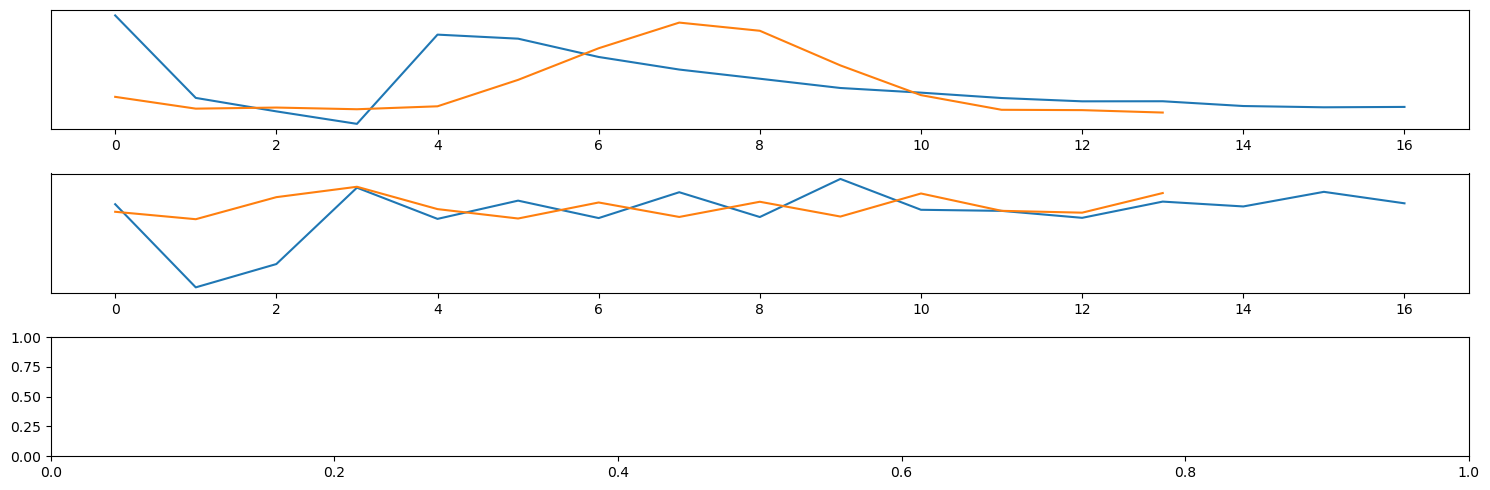

In [30]:
fig, ax = plt.subplots(max_level_of_decomposition + 1, 1, figsize=(15,5))
i=1
# for j, coef in zip(range(len(list_wavelet_coefficients)), list_wavelet_coefficients):
#     # First level is the approximation
#     if j == 0:
#         ax[j].plot(coef, label='label: ' + str(i))
#         ax[j].set_title('Approximation Coefficient.')
#     else:
#         ax[j].plot(coef, label='label: ' + str(i))
#         ax[j].set_title('Detail Coefficient: level ' + str(j) + '.')
#     ax[j].set_yticks([])

for j, coef in zip(range(len(list_wavelet_coefficients2)), list_wavelet_coefficients2):
    # First level is the approximation
    if j == 0:
        ax[j].plot(coef, label='label: ' + str(i))
    else:
        ax[j].plot(coef, label='label: ' + str(i))
    ax[j].set_yticks([])

for j, coef in zip(range(len(list_wavelet_coefficients3)), list_wavelet_coefficients3):
    # First level is the approximation
    if j == 0:
        ax[j].plot(coef, label='label: ' + str(i))
    else:
        ax[j].plot(coef, label='label: ' + str(i))
    ax[j].set_yticks([])

plt.tight_layout()

In [ ]:
a=1

In [ ]:

list_of_coeff_features_table = []
# Get features from wavelet coefficients
for coeff, decomp_level_name in zip(list_wavelet_coefficients, list_of_wavelet_decomposition_level_names):
    coeff_table = pd.DataFrame(coeff, index=signals_table.index)
    coeff_features_table = get_signal_features_table(coeff_table)
    coeff_features_table.columns = [decomp_level_name + '_' +
                                    column_name for column_name in coeff_features_table.columns]
    coeff_features_table.reset_index(inplace=True)
    list_of_coeff_features_table.append(coeff_features_table)

In [60]:
# Get training data
# table_training = table[table['Annotations'] > 0]
# Reshape table, storing one signal per row
signals_table_training = table_training.pivot(
    index='label',
    columns='frame',
    values='mean_intensity')

- get signals with annotations (DONE, currently filtering by specific label ID (to get noise parts as well))
  - get short-signals separated by class (DONE in `signal_by_class`)

  - calculate cross-correlations with composite signal(s) (DONE with one example above)

- caculate wavelets for short-signals

  - calculate cross-correlations of each short-signal decomposition level with corresponding decomposition level of composite signal(s)


- consider thrsholding or features to find potential matches
